Initial merged_df1 structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33676 entries, 0 to 33675
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   rawCounts    33676 non-null  int64         
 1   dark_counts  33676 non-null  int64         
 2   counts12     33676 non-null  int64         
 3   counts13     33676 non-null  int64         
 4   counts23     33676 non-null  int64         
 5   datetime     33676 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(5)
memory usage: 1.5 MB
None
Structure after merging with complete date range:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33676 entries, 0 to 33675
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  33676 non-null  datetime64[ns]
 1   counts12  33676 non-null  int64         
 2   counts13  33676 non-null  int64         
 3   counts23  33676

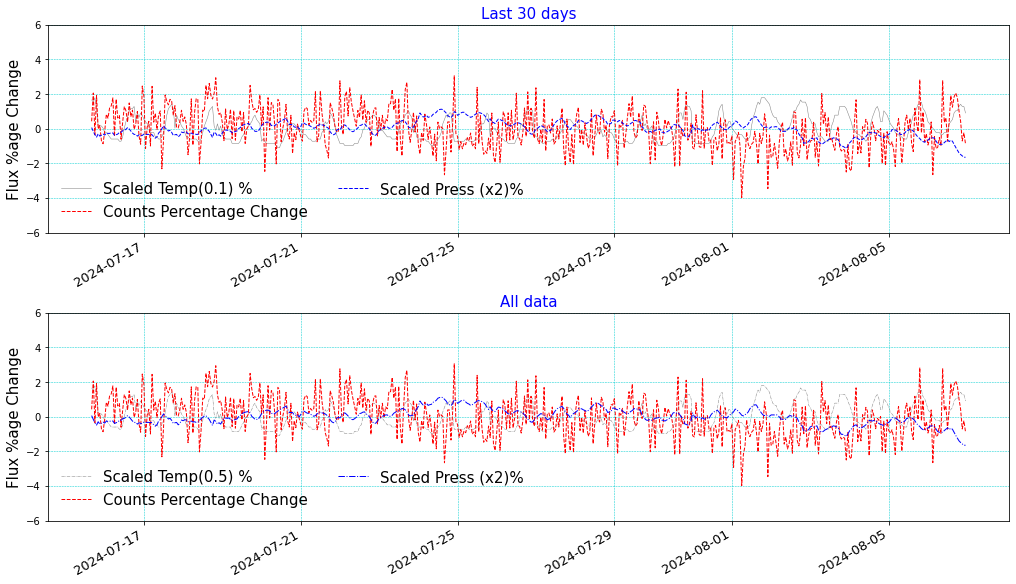

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.frequencies import to_offset
from datetime import datetime, timedelta

def merge_tables(df1, dfpt):
    t1start = pd.Timestamp(df1.index[0]).tz_localize(None)
    t1end = pd.Timestamp(df1.index[-1]).tz_localize(None)
    dfpt1 = dfpt.loc[t1start:t1end].copy()
    merged_tab = pd.merge(df1, dfpt1, how='inner', left_index=True, right_index=True)
    return merged_tab

def calc_percent_change(merged_df):
    merged_df["counts_pct"] = ((merged_df['counts12'] - merged_df['counts12'].mean()) / merged_df['counts12'].mean() * 100)
    merged_df["counts_m_avg"] = merged_df["counts_pct"].rolling('6H').mean()
    merged_df["press_pct"] = 2 * ((merged_df['mslp'] - merged_df['mslp'].mean()) / merged_df['mslp'].mean() * 100)
    merged_df["temp_pct"] = ((merged_df['tmpf'] - merged_df['tmpf'].mean()) / merged_df['tmpf'].mean() * 100)
    merged_df['temp_scaled'] = 0.1 * merged_df['temp_pct']
    merged_df["delta_cts"] = np.log((merged_df["counts12"]) / merged_df["counts12"].mean())
    merged_df["delta_pres"] = (merged_df["mslp"] - merged_df["mslp"].mean())
    return merged_df

# Specify the directory where your log files are stored
log_directory = '/home/cosmic/OneParkPlace'

# Get a list of all files in the directory
all_files = os.listdir(log_directory)

# Filter only files with a specific extension (e.g., '.log')
log_files = [file for file in all_files if file.endswith('.log')]

# Initialize an empty DataFrame
merged_df1 = pd.DataFrame()

# Iterate through each log file
for log_file in log_files:
    # Create the full path for the log file
    log_file_path = os.path.join(log_directory, log_file)
  
    # Read the log file into a DataFrame
    df = pd.read_csv(log_file_path, sep=',', names=["rawCounts", "dark_counts", "counts12", "counts13", "counts23", "datetime"])
    
    # Ensure the datetime column is in the correct format
    df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce').dt.floor('min')
    
    # Append the DataFrame to the merged_df1 DataFrame
    merged_df1 = pd.concat([merged_df1, df], axis=0, ignore_index=True)

# Check the structure of merged_df1
print("Initial merged_df1 structure:")
print(merged_df1.info())

# Drop non-numeric columns and unnecessary columns
merged_df1 = merged_df1.drop(columns=["rawCounts", "dark_counts"])

# Ensure the counts columns are numeric
merged_df1["counts12"] = pd.to_numeric(merged_df1["counts12"], errors='coerce')
merged_df1["counts13"] = pd.to_numeric(merged_df1["counts13"], errors='coerce')
merged_df1["counts23"] = pd.to_numeric(merged_df1["counts23"], errors='coerce')

# Create a continuous date-time range
date_range = pd.date_range(start=merged_df1["datetime"].min(), end=merged_df1["datetime"].max(), freq='1T')

complete_df = pd.DataFrame(date_range, columns=['datetime'])

# Merge the complete range with the original dataframe
merged_df1 = pd.merge(complete_df, merged_df1, on="datetime", how='left')

# Check the structure after merging
print("Structure after merging with complete date range:")
print(merged_df1.info())

# Identify hours with any missing data and set the entire hour's data to NaN
merged_df1['hour'] = merged_df1['datetime'].dt.floor('H')
missing_hours = merged_df1[merged_df1['counts12'].isna()]['datetime'].dt.floor('H').unique()

# Create a boolean mask to identify rows where 'hour' is in missing_hours
mask = merged_df1['hour'].isin(missing_hours)

# Set all columns except the datetime column to NaN where the mask is True
merged_df1.loc[mask, merged_df1.columns != 'datetime'] = np.nan

# Drop the 'hour' column as it was only needed for processing
merged_df1 = merged_df1.drop(columns=['hour'])

# Set the datetime column as the index
merged_df1 = merged_df1.set_index('datetime')

# Check the structure before resampling
print("Structure before resampling:")
print(merged_df1.info())

# Function to replace consecutive zeros with the average of nearest non-zero values
def replace_zeros_with_avg(df, col_name):
    zero_mask = (df[col_name] == 0)
    zero_groups = zero_mask.ne(zero_mask.shift()).cumsum()  # Create groups of consecutive zeros
    for group, values in df.loc[zero_mask, col_name].groupby(zero_groups):
        if len(values) > 0:
            before = df.loc[values.index.min() - pd.Timedelta(hours=1), col_name] if values.index.min() > df.index.min() else np.nan
            after = df.loc[values.index.max() + pd.Timedelta(hours=1), col_name] if values.index.max() < df.index.max() else np.nan
            avg = np.nanmean([before, after])
            df.loc[values.index, col_name] = avg

# Apply the function to 'counts12', 'counts13', and 'counts23' columns
replace_zeros_with_avg(merged_df1, 'counts12')
replace_zeros_with_avg(merged_df1, 'counts13')
replace_zeros_with_avg(merged_df1, 'counts23')

# Check the structure before resampling
print("Structure before resampling after replacing zeros:")
print(merged_df1.info())

# Resample to hourly data
df_hourly = merged_df1[['counts12', 'counts13', 'counts23']].resample('H').sum()

# Check the structure of df_hourly
print("Structure after resampling:")
print(df_hourly.info())

df_hourly.drop(df_hourly.head(1).index, inplace=True)
df_hourly.drop(df_hourly.tail(1).index, inplace=True)

fPT1 = 'mslp_temp.csv'
df1_PT = pd.read_csv(fPT1)
df1_PT.drop(df1_PT[df1_PT['mslp'] == 'M'].index, inplace=True)
df1_PT.drop(df1_PT[df1_PT['tmpf'] == 'M'].index, inplace=True)
df1_PT.dropna(inplace=True)
df1_PT['valid'] = pd.to_datetime(df1_PT['valid'], utc=True)
df1_PT = df1_PT.set_index('valid').tz_localize(None)  # Ensure it is timezone naive
df1_PT = df1_PT.drop(columns=["station"])
loffset = '-52min'
df1_PT.index = df1_PT.index + to_offset(loffset)
df1_PT["mslp"] = df1_PT["mslp"].astype(str).astype(float)
df1_PT["tmpf"] = df1_PT["tmpf"].astype(str).astype(float)

merged_df1 = merge_tables(df1_PT, df_hourly)
merged_df1 = merged_df1.rename_axis('date')
merged_df1.to_csv('/home/cosmic/OneParkPlace/OneParkPlace_merged.csv')

now = datetime.utcnow().date()
yesterday = datetime.utcnow().date() - timedelta(days=1)
lastmonth = datetime.utcnow().date() - timedelta(days=31)

merged_df_1day = merged_df1.loc[yesterday:now].copy()
merged_df_31days = merged_df1.loc[lastmonth:now].copy()

merged_df = calc_percent_change(merged_df1)
calc_percent_change(merged_df_1day)
calc_percent_change(merged_df_31days)

fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = fig.add_gridspec(2)
axs = gs.subplots(sharex=False, sharey=False)

axs[0].set_title("Last 30 days", fontsize=15, color='blue')
axs[0].plot(merged_df_31days['temp_scaled'],
            linestyle='-', linewidth=0.5, color='gray', label='Scaled Temp(0.1) %')
axs[0].plot(merged_df_31days['counts_pct'],
            linestyle='--', linewidth=1, color='red', label='Counts Percentage Change')
axs[0].plot(merged_df_31days['press_pct'],
            linestyle='--', linewidth=1, color='blue', label='Scaled Press (x2)%')

axs[1].set_title("All data", fontsize=15, color='blue')
axs[1].plot(merged_df['temp_scaled'],
            linestyle='-.', linewidth=0.5, color='gray', label='Scaled Temp(0.5) %')
axs[1].plot(merged_df["counts_pct"],
            linestyle='--', linewidth=1, color='red', label='Counts Percentage Change')
axs[1].plot(merged_df["press_pct"],
            linestyle='-.', linewidth=1, color='blue', label='Scaled Press (x2)%')

axs[0].set_ylabel('Flux %age Change', fontsize=15)
axs[0].set_ylim(-6, 6)
axs[0].legend(ncol=2, frameon=False, fontsize=15)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].grid(True, color='DarkTurquoise', alpha=1, linestyle='--', linewidth=0.5)

axs[1].set_ylabel('Flux %age Change', fontsize=15)
axs[1].set_ylim(-6, 6)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].legend(ncol=2, frameon=False, fontsize=15)
axs[1].grid(True, color='DarkTurquoise', alpha=1, linestyle='--', linewidth=0.5)

plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('/home/cosmic/onlineMon/images/OneParkPlace_pct_Ch_mostrecent.png')
plt.show()
